In [1]:
pwd()

"/home/kyan/Projects/qgplsim"

# DGP

In [2]:
using DelimitedFiles, Distributions

In [132]:
student_t = StudentizedRange(2, 4)

StudentizedRange{Float64}(ν=2.0, k=4.0)

In [135]:
@time rand(student_t, 1000)
d2 = Cauchy(0,1)
@time rand(d2, 1000)
@time randn(1000)
d2

  6.712398 seconds (1 allocation: 7.938 KiB)
  0.000038 seconds (1 allocation: 7.938 KiB)
  0.000011 seconds (1 allocation: 7.938 KiB)


Cauchy{Float64}(μ=0.0, σ=1.0)

In [11]:
ϵt = rand(student_t, 10000)
filename = "studentized.txt"
open(filename, "a") do io
    writedlm(io, ϵt)
end

In [14]:
et = readdlm(filename, Float64)
size(et)

(12000, 1)

In [37]:
dtn = TruncatedNormal(0,1, -3, 3)
dt = Normal(0, 1)

Normal{Float64}(μ=0.0, σ=1.0)

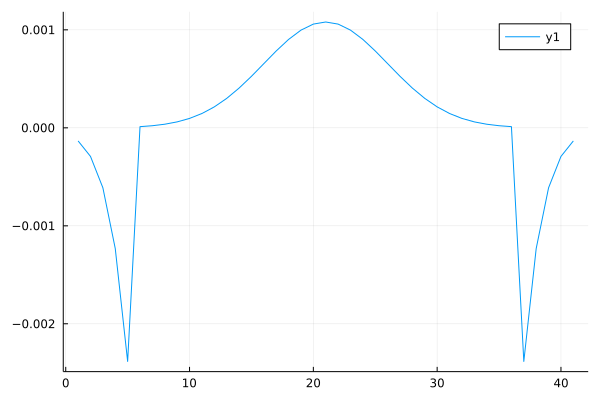

In [39]:
plot(pdf(dtn, -4:0.2:4) .- pdf(dt, -4:0.2:4))
# plot!(pdf(dt, -4:0.2:4))

# QGPLSIM fitting

In [75]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra, Clustering

In [79]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x, α[1] = c0
θ = [ 0.0, 1.0, 2.0, 1.0./2.0, -1.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [1.0, -0.5]  * 1.0 # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] * 1.0

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n4 = 2000
n5 = 3000
n6 = 4000
n7 = 6000
n8 = 8000
n9 = 12000
n = n4

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
widthExp = -0.17
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, widthExp, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  4.854679 seconds (24.54 M allocations: 2.272 GiB, 9.05% gc time)
Estimation of index coefs: 
̂α => [0.21248123706388536, -0.09624953986830401, 0.8670727476194878, 0.44019609301597956]
̂γ => [0.29900411401097055, -0.12118620082129546]
Estimation of linear coefs: 
̂θ => [1.00166359502096; 1.981134603392274; 0.4953614991236209; -1.0260560897160482]
̂β => [0.7684875582094627, -0.61876568278163]


In [74]:
alpha ./ alpha[1] |> transpose

1×4 transpose(::Vector{Float64}) with eltype Float64:
 1.0  -0.544762  4.30985  2.16411

In [64]:
norm(α)

4.716990566028302

In [65]:
gamma * norm(α)

2-element Vector{Float64}:
  1.1843709285223867
 -0.7333549938638811

# QGPLSIM prediction

In [66]:
using Plots

In [67]:
a = α[2:end]
a = a/norm(a)

4-element Vector{Float64}:
  0.21693045781865616
 -0.10846522890932808
  0.8677218312746247
  0.4338609156373123

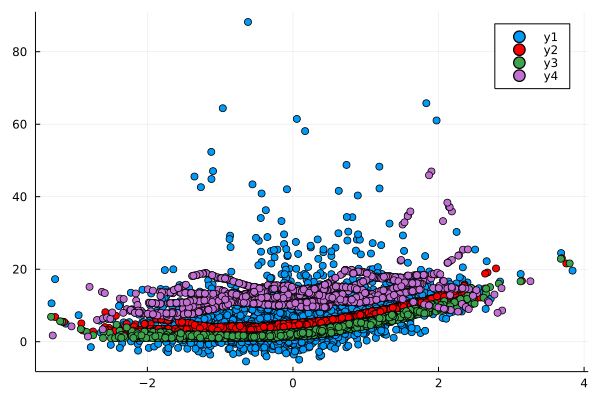

In [68]:
X, Z, y = dgp(n, γ, θ, α, β, fx, dist, ifz, 1.6)
v = X*a
model1 = qgplsim.model(X, Z, y, 0.5)
qgplsim.estimator(model1)
v1 = X * model1.alpha
yp1 = qgplsim.predict(model1, X, Z, 0)

model2 = qgplsim.model(X, Z, y, 0.1)
qgplsim.estimator(model2)
v2 = X * model2.alpha
yp2 = qgplsim.predict(model2, X, Z, 0)

model3 = qgplsim.model(X, Z, y, 0.9)
qgplsim.estimator(model3)
v3 = X * model3.alpha
yp3 = qgplsim.predict(model3, X, Z, 0)

scatter(v, y)
scatter!(v1, yp1, color = "red")
scatter!(v2, yp2)
scatter!(v3, yp3)

## Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 0.38017170905418
dy = 1.5176059031263207
dx = 4.031190450229145


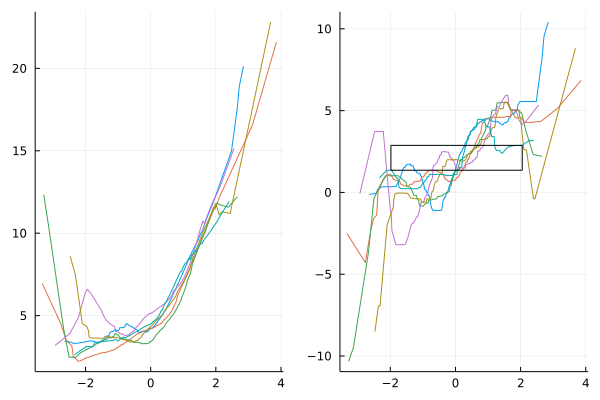

In [69]:
g = zeros(n)
dg = zeros(n)
yz = y - X * theta


X = [ones(n, intercept) X]
v = X * alpha
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h # + h
    vkmax = maximum(vk) - h# - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [214]:
Threads.nthreads()

2

In [19]:
include("MonteCarloSIM.ji")

α = [-1.0, 1.0, -3.0] # single index for x
θ = [0.0, 3.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0]  # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 
widthExp = -0.17
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 500
fx = 2
dist = 0 # 1 for t
intercept = 0
rep = 100 # MC rept. times

100

# Monte Carlo Simulation

In [20]:
@time Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, widthExp, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

 50.054629 seconds (478.15 M allocations: 195.403 GiB, 25.74% gc time, 2.51% compilation time)


1×2 Matrix{Float64}:
 0.387341  0.776403

In [248]:
var1 = var(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0203873  0.0103886

In [10]:
mt1

1×2 Matrix{Float64}:
 1.02292  1.98037

In [8]:
ma1

1×2 Matrix{Float64}:
 0.886613  -0.456838

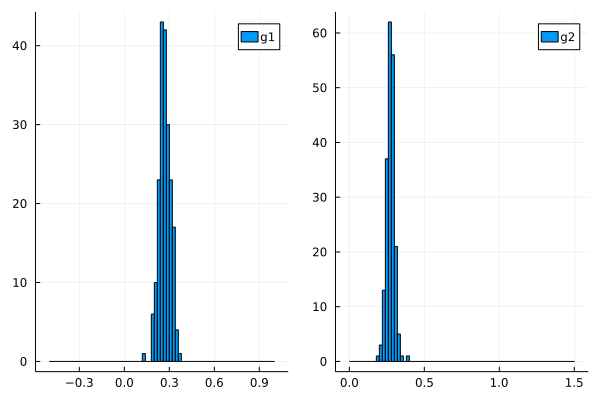

In [159]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

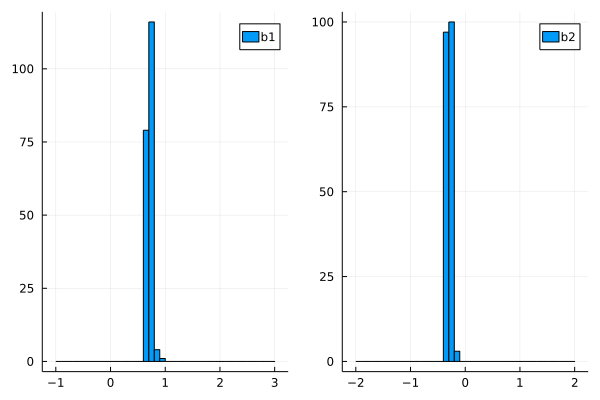

In [147]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

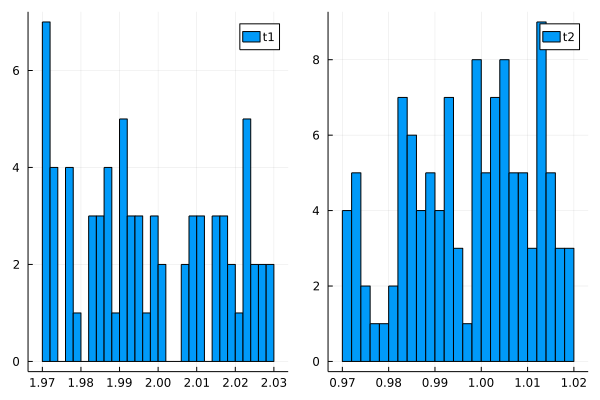

In [14]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

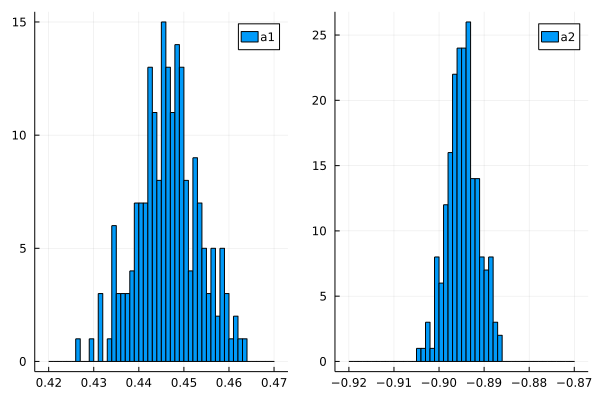

In [16]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

# Postprocess

In [82]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x
# lenα = norm(α)
θ = [0.0, 1.0, 2.0, 0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β2 = [0.5, -0.5] # linear for z
β3 = [0.5, -0.5, -0.5] # linear for z
Γ2 = [[0.5, 0.001], [0.5, 1.0], [0.001, 0.5], [1.0, 0.5], [0.5, 0.5]] 
Γ3 = [[0.001, 0.001, 0.001], [0.001, 0.5, 0.5], [0.001, 0.5, 1.0], [0.5, 0.5, 0.5], [0.5, 1.0, 2.0]] 
include("postprocess.ji")

mean_var (generic function with 4 methods)

In [209]:
index_a = 1:4
index_g = 5:6
index_t = 7:10
lena = norm(α)

4.716990566028302

In [257]:
table = zeros(15,8)

table = string.(table)

15×8 Matrix{String}:
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"

In [251]:
function string_agbt(mse_g)

        mmg = round(mean(mse_g), digits=4) |> string
        vmg = round(var(mse_g) |> sqrt, digits=4) |> string
            if length(mmg) < 6
            mmg = string(mmg, "0")
        end
        if length(vmg) < 6
            vmg = string(vmg, "0")
        end
    string(mmg, '(', vmg, ')')
end

string_agbt (generic function with 1 method)

In [266]:
N = [500, 1000, 2000] # 500 , 1000, 2000
D = [0, 1, 2]

3-element Vector{Int64}:
 0
 1
 2

In [286]:
for f in 1:2
for gk in 1:5
    γ = Γ2[gk] 
    ind_gk = 3*gk - 2
    table[ind_gk, 1] = round.(γ, digits=1) |> string
    for nk in 1:3
        ind_nk = ind_gk + nk - 1
        table[ind_nk, 2] = string(N[nk])
        for dk in 1:3
            agbt = read_agbt(N[nk],f,D[dk],gk)
            Gamma = agbt[:, index_g] * lena * 0.83
            Alpha = agbt[:, index_a] * lena
            mse_g = mse(Gamma, γ)
            mse_a = mse(Alpha, α[2:end])
            # println(s)
            table[ind_nk, 2*dk+1] = string_agbt(mse_g)
            table[ind_nk, 2*dk+2] = string_agbt(mse_a)

            # println(mean(Gamma, dims = 1))
        end
    end
end

dt = DataFrame(table, [[:γ, :n]; repeat([:gamma, :alpha], 3)], makeunique=true)

CSV.write("model$f.csv", dt)
end

In [137]:
agbt = read_agbt(500,2,2,1)
mean(agbt, dims=1)

1×12 Matrix{Float64}:
 0.235541  -0.0631896  0.618301  0.316388  …  -0.838207  0.515621  -0.63708

In [61]:
var(mse_g)

0.22279491171614488

In [76]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.45832  0.990662

In [41]:
Alpha = agbt2[:, 1:4] * lena
mean(Alpha, dims = 1)

1×4 Matrix{Float64}:
 0.993321  -0.450712  3.98013  2.02877

In [48]:
mse(Alpha, α[2:end], 100)

1.1065700508932266

In [46]:
α

5-element Vector{Float64}:
 -1.0
  1.0
 -0.5
  4.0
  2.0